<a href="https://colab.research.google.com/github/kerryqliu/stats170/blob/kerry/doc2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This was the notebook we used to try out a logistic regression classifier using doc2vec vectors

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


# Pull info from database

In [2]:
from sqlalchemy import create_engine
engine = create_engine(#password and database location goes here)

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [3]:
testQuery = "SELECT d.docid, f.completetext, d.label from completeDocs f join documentLabels d on f.docid = d.docid where d.docid <= 114;"
docs = pd.read_sql_query(testQuery, con=engine)
docs

,docid,completetext,label
0,1,Example 1\nReferring Doctor: Unknown Provider\...,1.0
1,2,Example 2\nProgress Notes\nDate:\nPatient:\nDa...,1.0
2,3,Example 3\nChief Complaint:\n1. Rapidly progre...,4.0
3,4,14.0 mm MALIA.\nLAVA\nPELSING U/LNWAL900-#-WEL...,1.0
4,5,The first set of documents behind this cover p...,1.0
...,...,...,...
109,110,TUE 15:24\nFAX\n2002/023\nPATIENT:\nDATE OF BI...,1.0
110,111,9:10\nFAX\n2002/041\nPatient Name:\nAddress:\n...,1.0
111,112,";\n# 237,24\nPilloU UI\nScan or\nby User:\nLAB...",1.0
112,113,15:03 From\nPage: 1.24\nNUFACTOR\nwww.NUFACTOR...,1.0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


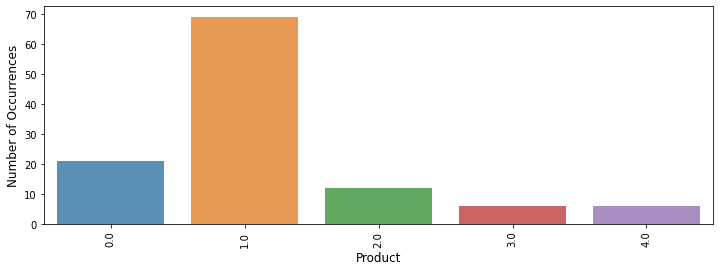

In [ ]:
cnt_pro = docs['label'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Product', fontsize=12)
plt.xticks(rotation=90)
plt.show();

After grouping our labels are:
1: reduced reflexes
2: normal or unrelated to reflexes
3: increased reflexes

# Start Training

In [4]:
import multiprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectPercentile, f_classif
cores = multiprocessing.cpu_count()

In [5]:
# consider scaling the vectors?
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, epochs=100)) for doc in sents])
    return targets, regressors

In [6]:
from sklearn.model_selection import cross_val_score

# BioSentVec

In [7]:
!git clone https://github.com/epfml/sent2vec.git

Cloning into 'sent2vec'...
remote: Enumerating objects: 396, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 396 (delta 0), reused 1 (delta 0), pack-reused 393
Receiving objects: 100% (396/396), 439.62 KiB | 7.58 MiB/s, done.
Resolving deltas: 100% (247/247), done.


In [8]:
%cd sent2vec

/content/sent2vec


In [9]:
!python setup.py build_ext
!pip install .

Compiling src/sent2vec.pyx because it changed.
[1/1] Cythonizing src/sent2vec.pyx
/usr/local/lib/python3.7/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/sent2vec/src/sent2vec.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
running build_ext
building 'sent2vec' extension
creating build
creating build/temp.linux-x86_64-3.7
creating build/temp.linux-x86_64-3.7/src
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fdebug-prefix-map=/build/python3.7-OGiuun/python3.7-3.7.10=. -fstack-protector-strong -Wformat -Werror=format-security -g -fdebug-prefix-map=/build/python3.7-OGiuun/python3.7-3.7.10=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -Isrc -I/usr/local/lib/python3.7/dist-packages/numpy/core/include -I/usr/include/python3.7m -c src/sent2vec.cpp -o build

In [10]:
%cd ..

/content


In [11]:
import sent2vec
from nltk import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
from scipy.spatial import distance

In [12]:
model_path = '/content/drive/Shareddrives/CAPSTONE/Resources/BioSentVec_PubMed_MIMICIII-bigram_d700.bin'
model = sent2vec.Sent2vecModel()
try:
    model.load_model(model_path)
except Exception as e:
    print(e)
print('model successfully loaded')

model successfully loaded


In [13]:
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [14]:
stop_words = set(stopwords.words('english'))
def preprocess_sentence(text):
    text = text.replace('/', ' / ')
    text = text.replace('.-', ' .- ')
    text = text.replace('.', ' . ')
    text = text.replace('\'', ' \' ')
    text = text.lower()

    tokens = [token for token in word_tokenize(text) if token not in punctuation and token not in stop_words]

    return ' '.join(tokens)

In [15]:
from bs4 import BeautifulSoup
def cleanText(text):
    text = text.lower()
    text = re.sub(r'[.,!?:]', '', text)
    text = re.sub(r'\n', ' ', text)
    return text

In [16]:
# Function for pubmeb vectors
# consider scaling the vectors?
def vec_from_model(model, df):
    labels = []
    vectors = []
    for i in range(len(df)):
      if df.iloc[i].label == 4:
        labels.append(3)
      elif df.iloc[i].label == 0:
        labels.append(2)
      else:
        labels.append(df.iloc[i].label)
      vectors.append(model.embed_sentence(cleanText(docs.iloc[i].completetext))[0])
    return labels, vectors

Repeated k-fold cross validation

In [17]:
accuracy = []
f1 = []
mean_acc = []
mean_f1 = []
train_dict = dict()
test_dict = dict()
train_f1_dict = dict()
test_f1_dict = dict()
train_f1_macro = dict()
test_f1_macro = dict()
y_tests = dict()
y_preds = dict()
kfold = StratifiedKFold(n_splits=6, shuffle=True)
C = [10000, 1000, 100, 10, 1, .1,.01,.001]
for term in C:
  train_dict[term] = []
  test_dict[term] = []
  train_f1_dict[term] = []
  test_f1_dict[term] = []
  train_f1_macro[term] = []
  test_f1_macro[term] = []
  y_tests[term] = []
  y_preds[term] = []
  for i in range(5):
    test_acc = []
    train_acc = []
    train_f1 = []
    test_f1 = []
    train_macro = []
    test_macro = []
    preds = []
    tests = []
    for train, test in kfold.split(docs['completetext'], docs['label']):
      # set up the model below
      train, test = docs.iloc[train], docs.iloc[test]
      
      y_train, X_train = vec_from_model(model, train)
      y_test, X_test = vec_from_model(model, test)

      logreg = LogisticRegression(penalty = 'l1', n_jobs=1, C=term, max_iter = 600, solver='saga')
      logreg.fit(X_train, y_train)
      y_pred = logreg.predict(X_test)
      y_train_pred = logreg.predict(X_train)
      from sklearn.metrics import accuracy_score, f1_score
      # print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
      # print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
      test_acc.append(accuracy_score(y_test, y_pred))
      train_acc.append(accuracy_score(y_train, y_train_pred))
      test_f1.append(f1_score(y_test, y_pred, average='weighted'))
      train_f1.append(f1_score(y_train, y_train_pred, average='weighted'))
      test_macro.append(f1_score(y_test, y_pred, average='macro'))
      train_macro.append(f1_score(y_train, y_train_pred, average='macro'))
      tests.append(y_test)
      preds.append(y_pred)
      # y_preds.append(y_pred)
      # y_tests.append(y_test)
    train_dict[term].append(train_acc)
    test_dict[term].append(test_acc)
    train_f1_dict[term].append(train_f1)
    test_f1_dict[term].append(test_f1)
    train_f1_macro[term].append(train_macro)
    test_f1_macro[term].append(test_macro)
    y_tests[term].append(tests)
    y_preds[term].append(preds)

print("Mean accuracy: ", np.mean(accuracy))
print("Mean F1: ", np.mean(f1))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

Mean accuracy:  nan
Mean F1:  nan


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
train_dict[0.001]

[[0.29473684210526313,
  0.6,
  0.6,
  0.6105263157894737,
  0.6105263157894737,
  0.6105263157894737],
 [0.6, 0.6, 0.6, 0.6105263157894737, 0.6105263157894737, 0.6105263157894737],
 [0.6, 0.6, 0.6, 0.28421052631578947, 0.6105263157894737, 0.6105263157894737],
 [0.6,
  0.6,
  0.29473684210526313,
  0.6105263157894737,
  0.6105263157894737,
  0.6105263157894737],
 [0.6, 0.6, 0.6, 0.6105263157894737, 0.6105263157894737, 0.6105263157894737]]

In [ ]:
mean_test_acc = []
mean_train_acc = []
mean_test_f1 = []
mean_train_f1 = []
mean_test_macro = []
mean_train_macro = []
for key in train_dict:
  mean_test_acc.append(np.mean([np.mean(i) for i in test_dict[key]]))
  mean_train_acc.append(np.mean([np.mean(i) for i in train_dict[key]]))
  mean_test_f1.append(np.mean([np.mean(i) for i in test_f1_dict[key]]))
  mean_train_f1.append(np.mean([np.mean(i) for i in train_f1_dict[key]]))
  mean_test_macro.append(np.mean([np.mean(i) for i in test_f1_macro[key]]))
  mean_train_macro.append(np.mean([np.mean(i) for i in train_f1_macro[key]]))

In [ ]:
mean_test_acc

[0.4807017543859649,
 0.43684210526315786,
 0.45087719298245615,
 0.5578947368421053,
 0.6052631578947368,
 0.6052631578947368,
 0.5964912280701754,
 0.5929824561403508]

In [ ]:
mean_test_acc

[0.4807017543859649,
 0.43684210526315786,
 0.45087719298245615,
 0.5578947368421053,
 0.6052631578947368,
 0.6052631578947368,
 0.5964912280701754,
 0.5929824561403508]

In [ ]:
mean_test_f1

[0.4818147377666828,
 0.44007403021590663,
 0.45094275975740505,
 0.48921590291584244,
 0.45676287492925854,
 0.45676287492925854,
 0.4476634597245802,
 0.444119034144501]

In [ ]:
mean_test_macro

[0.3168482011815345,
 0.3358319898030043,
 0.30795227477836173,
 0.28651366329144107,
 0.25125448028673836,
 0.25125448028673836,
 0.24843966547192356,
 0.25125448028673836]

In [ ]:
mean_test_macro

[0.3168482011815345,
 0.3358319898030043,
 0.30795227477836173,
 0.28651366329144107,
 0.25125448028673836,
 0.25125448028673836,
 0.24843966547192356,
 0.25125448028673836]

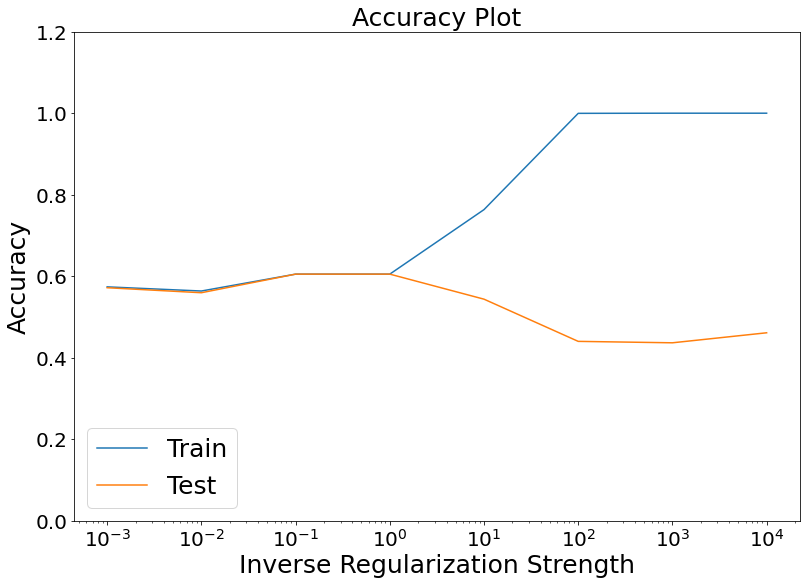

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(13,9))
plt.semilogx(C, mean_train_acc, label='Train')
plt.semilogx(C, mean_test_acc, label='Test')
plt.ylim([0, 1.2])
plt.title("Accuracy Plot", fontsize = 25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Inverse Regularization Strength', fontsize=25)
plt.ylabel('Accuracy', fontsize=25)
plt.legend(loc='lower left', prop={'size': 25})
plt.show()

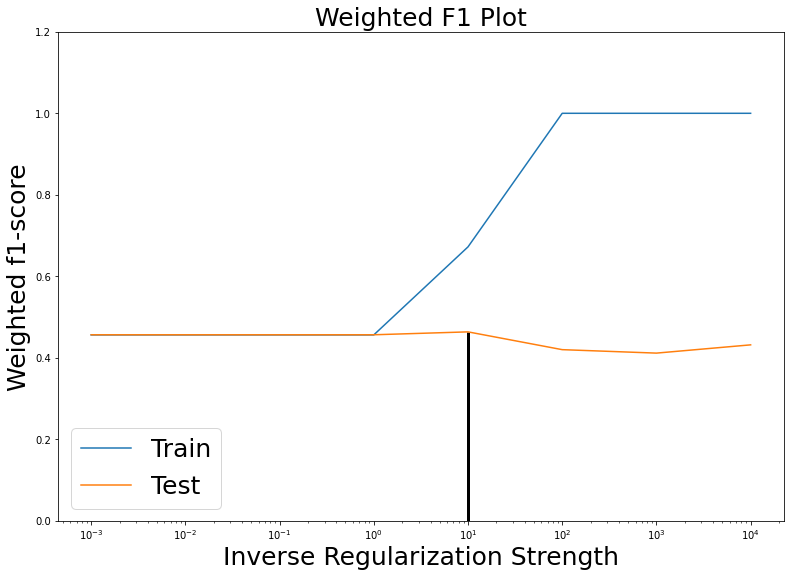

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(13,9))
plt.semilogx(C, mean_train_f1, label='Train')
plt.semilogx(C, mean_test_f1, label='Test')
plt.ylim([0, 1.2])
plt.vlines(10, plt.ylim()[0], 0.4638947050718805, color='k',
           linewidth=3)
plt.title("Weighted F1 Plot", fontsize = 25)
plt.xlabel('Inverse Regularization Strength', fontsize=25)
plt.ylabel('Weighted f1-score', fontsize=25)
plt.legend(loc='lower left', prop={'size': 25})
plt.show()

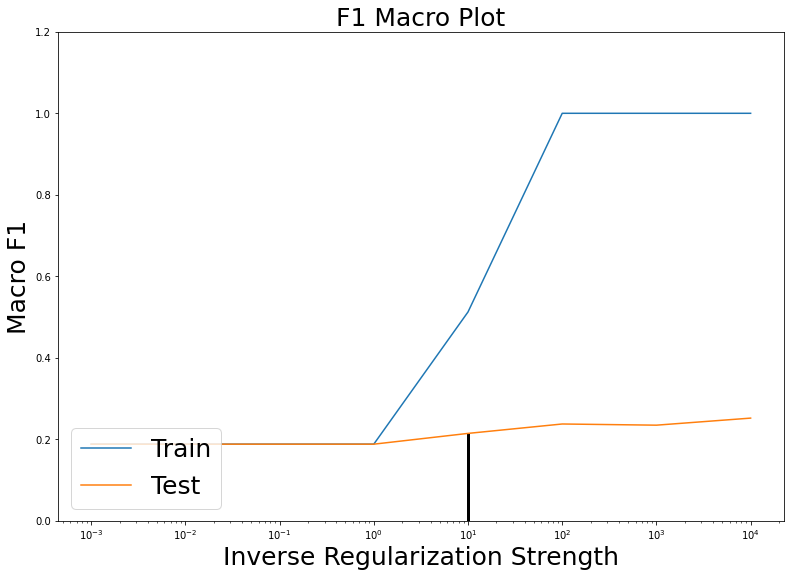

In [ ]:
fig, ax = plt.subplots(figsize=(13,9))
plt.semilogx(C, mean_train_macro, label='Train')
plt.semilogx(C, mean_test_macro, label='Test')
plt.ylim([0, 1.2])
plt.vlines(10, plt.ylim()[0], 0.214868555921207, color='k',
           linewidth=3)
plt.title("F1 Macro Plot", fontsize = 25)
plt.xlabel('Inverse Regularization Strength', fontsize=25)
plt.ylabel('Macro F1', fontsize=25)
plt.legend(loc='lower left', prop={'size': 25})
plt.show()

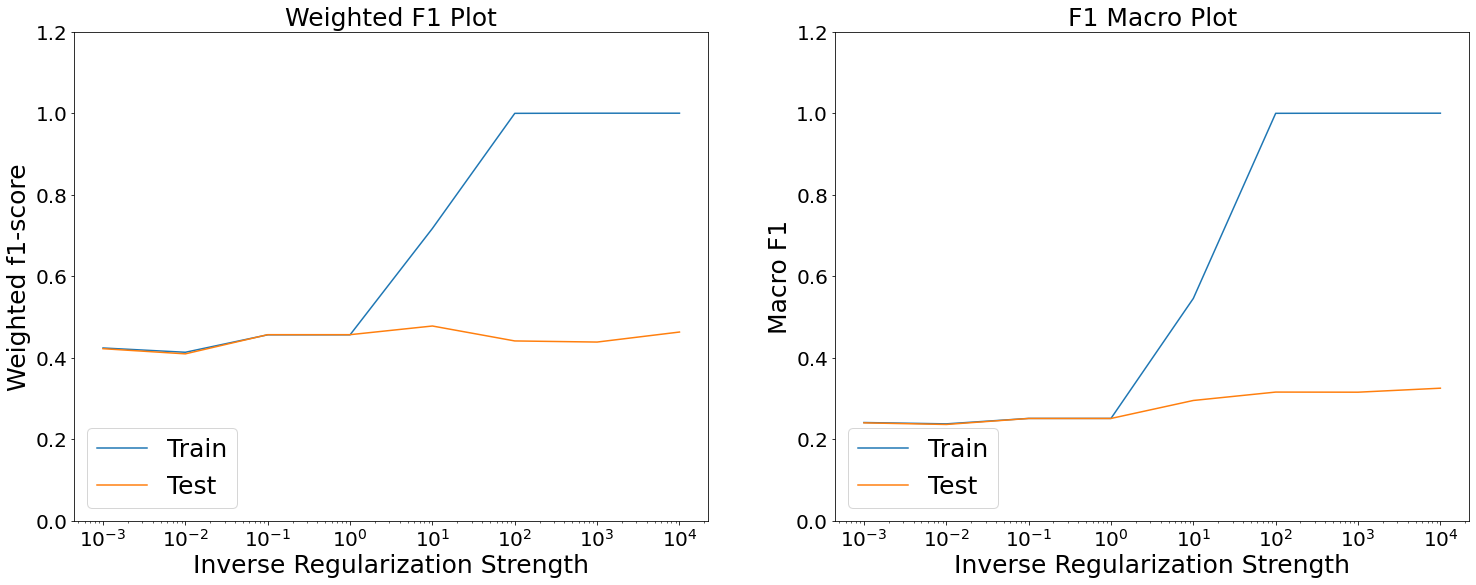

In [ ]:
fig, (ax2, ax3) = plt.subplots(1, 2, figsize=(25,9))

ax2.semilogx(C, mean_train_f1, label='Train')
ax2.semilogx(C, mean_test_f1, label='Test')
ax2.set_ylim([0, 1.2])
ax2.set_title("Weighted F1 Plot", fontsize = 25)
ax2.set_xlabel('Inverse Regularization Strength', fontsize=25)
ax2.set_ylabel('Weighted f1-score', fontsize=25)
ax2.tick_params(axis='y', labelsize= 20)
ax2.tick_params(axis='x', labelsize= 20)
ax2.legend(loc='lower left', prop={'size': 25})

ax3.semilogx(C, mean_train_macro, label='Train')
ax3.semilogx(C, mean_test_macro, label='Test')
ax3.set_ylim([0, 1.2])
ax3.set_title("F1 Macro Plot", fontsize = 25)
ax3.set_xlabel('Inverse Regularization Strength', fontsize=25)
ax3.set_ylabel('Macro F1', fontsize=25)
ax3.tick_params(axis='y', labelsize= 20)
ax3.tick_params(axis='x', labelsize= 20)
ax3.legend(loc='lower left', prop={'size': 25})
plt.show()


# Overall, around 10 appears to be the best regularization strength. 

In [ ]:
"hi".split()

['hi']